In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
from utils.functions import get_files_info
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
def calculate_ndvi(red_band, nir_band):
    denominator = nir_band + red_band
    ndvi = np.where(
        denominator != 0,
        (nir_band - red_band) / denominator,
        0.0
    )
    return ndvi

def vectorize_sentinel_ndvi_256(file_path, red_idx=3, nir_idx=7):
    with rasterio.open(file_path) as src:
        img = src.read() 

        red = img[red_idx].astype(np.float32)
        nir = img[nir_idx].astype(np.float32)

        ndvi = calculate_ndvi(red, nir)    
        X = ndvi.reshape(-1)                

    return X

def load_rgb_timestamp(path):
    with rasterio.open(path) as src:
        img = src.read() / 4000
        rgb = np.stack([img[3], img[2], img[1]], axis=-1)  
    return rgb

In [3]:
base_dir = "s2_ejura_2018_2019"
n_files, name_files = get_files_info(base_dir)

name_files = sorted(name_files)
full_paths = [os.path.join(base_dir, fname) for fname in name_files]

ndvi_time_series = []

for file_path in full_paths:
    ndvi_vector = vectorize_sentinel_ndvi_256(file_path)
    ndvi_time_series.append(ndvi_vector)

ndvi_time_series = np.array(ndvi_time_series)

X = ndvi_time_series.T 
X.shape

Total number of files: 26


(65536, 26)

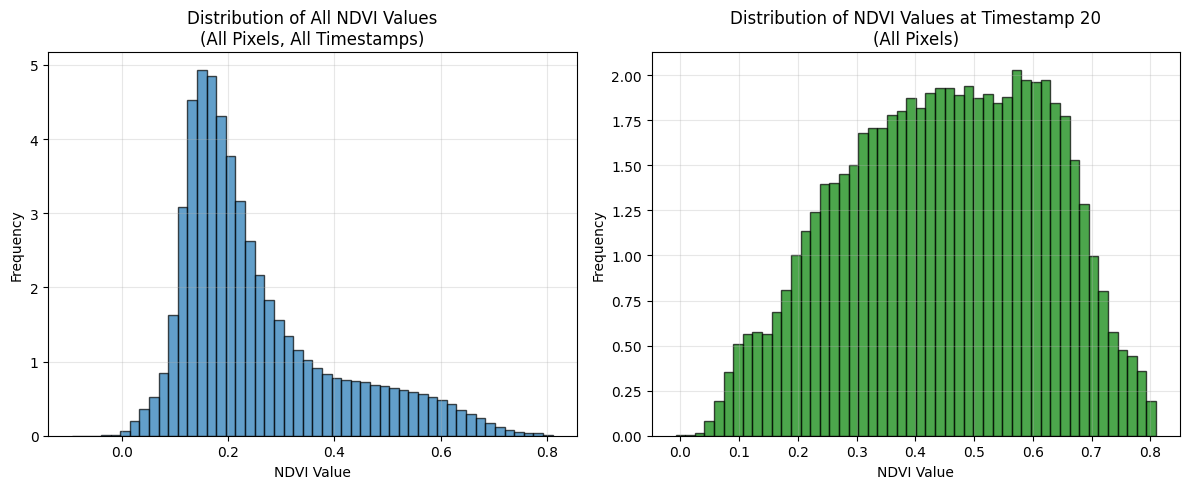

In [5]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(X.flatten(), bins=50, edgecolor='black', alpha=0.7, density=True)
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.title('Distribution of All NDVI Values\n(All Pixels, All Timestamps)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
timestamp_idx = 20
ndvi_at_timestamp = X[:, timestamp_idx]
p_x = plt.hist(ndvi_at_timestamp, bins=50, edgecolor='black', alpha=0.7, color='green', density=True)
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.title(f'Distribution of NDVI Values at Timestamp {timestamp_idx}\n(All Pixels)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Normalize
scaler = StandardScaler()
timestamp = 10
X_norm = scaler.fit_transform(X[:, timestamp].reshape(-1, 1))
# X_norm = scaler.fit_transform(X)

# Clustering
K = 5
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_norm)

# Estimate Gaussian parameters for each cluster
mu = np.zeros((K, X.shape[1]))
sigma = np.zeros((K, X.shape[1]))
for c in range(K):
    cluster_data = X[cluster_labels == c]  
    mu[c] = np.mean(cluster_data, axis=0)
    sigma[c] = np.std(cluster_data, axis=0)


# Compute log-likelihood for each pixel
log_likelihood = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    c = cluster_labels[i]
    log_likelihood[i] = np.sum(norm.logpdf(X[i], mu[c], sigma[c]))


# Identify anomalies based on log-likelihood
epsilon = 1e-3
anomalies = log_likelihood < epsilon

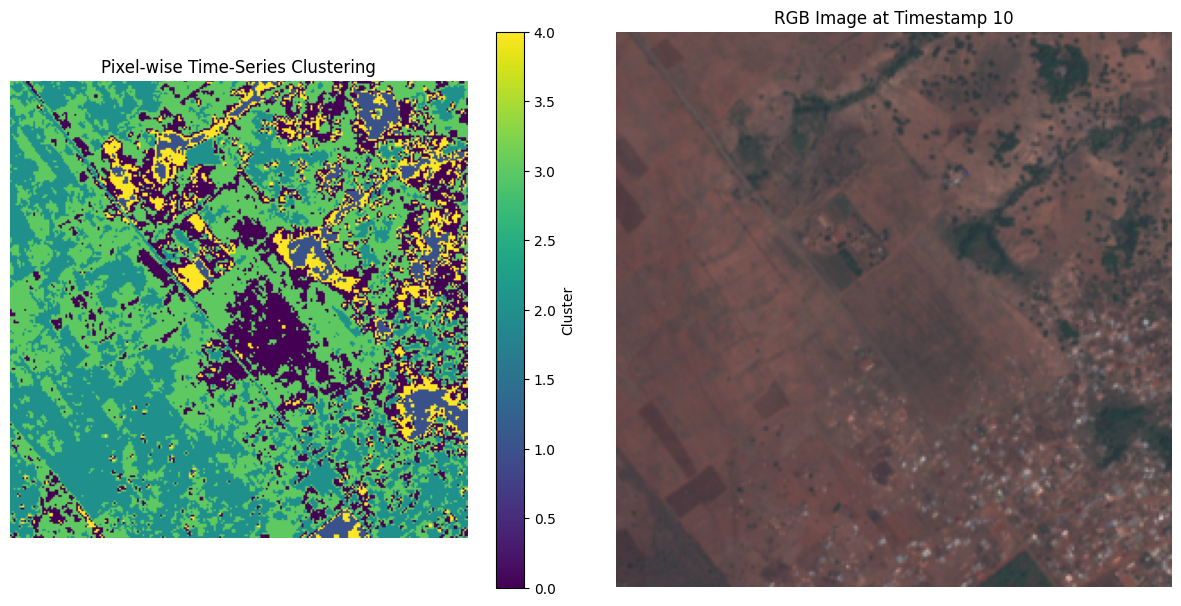

In [14]:
H = W = 256  
cluster_map = cluster_labels.reshape(H, W)
rgb = load_rgb_timestamp(os.path.join(base_dir, name_files[timestamp]))


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cluster_map)
plt.title("Pixel-wise Time-Series Clustering")
plt.axis("off")
plt.colorbar(label="Cluster")

plt.subplot(1, 2, 2)
plt.imshow(rgb)
plt.title(f"RGB Image at Timestamp {timestamp}")
plt.axis("off")
plt.tight_layout()
plt.show()


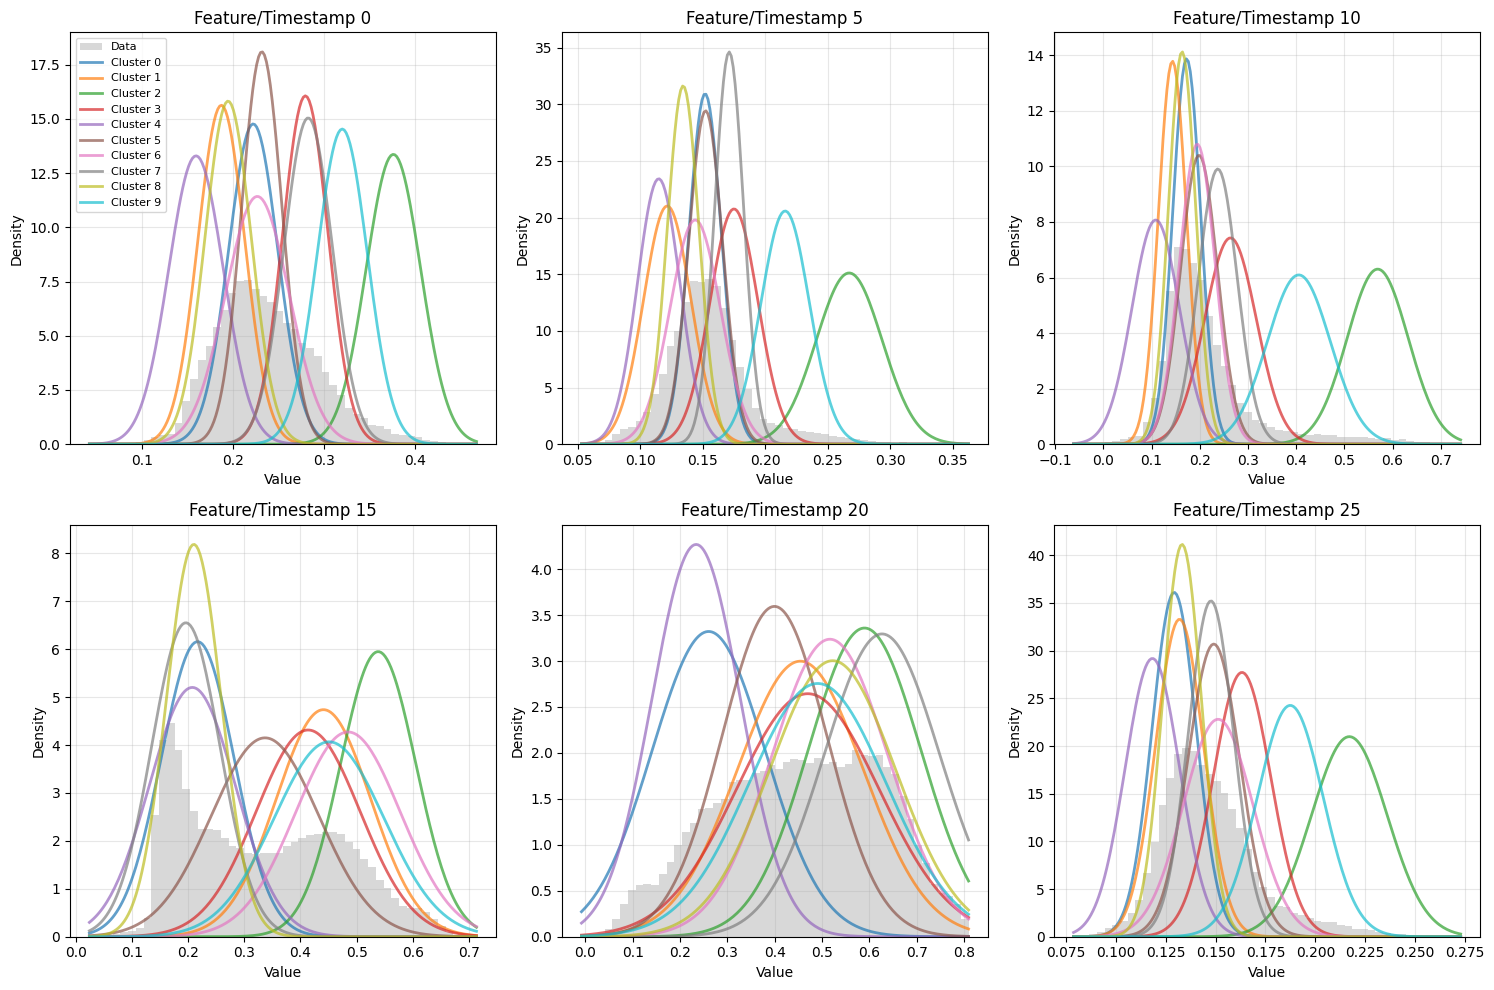

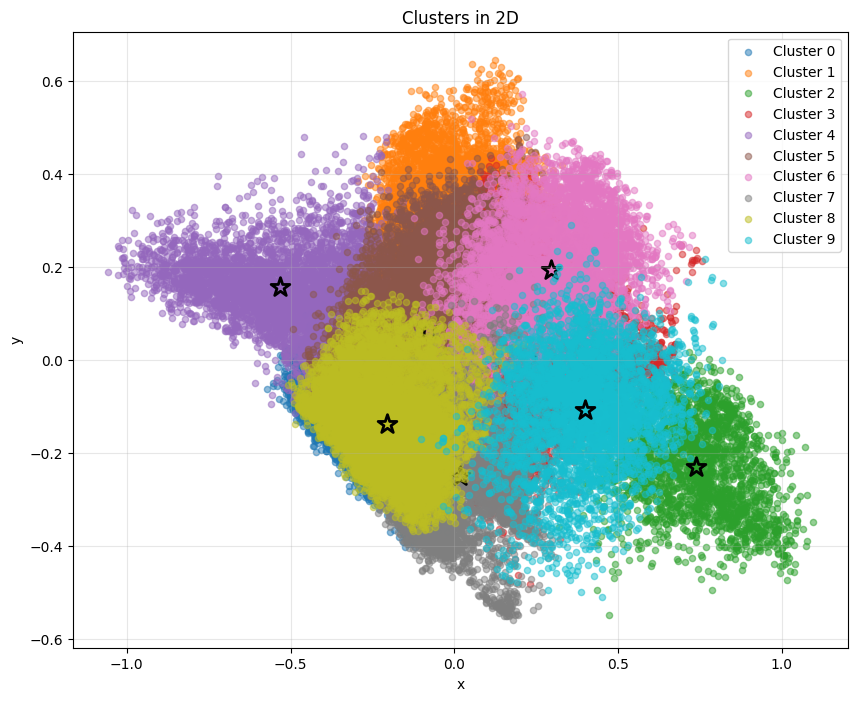

Cluster Statistics:
Number of clusters: 10
Cluster 0: 7885 points (12.0%)
Cluster 1: 7325 points (11.2%)
Cluster 2: 2251 points (3.4%)
Cluster 3: 7751 points (11.8%)
Cluster 4: 4112 points (6.3%)
Cluster 5: 10958 points (16.7%)
Cluster 6: 5690 points (8.7%)
Cluster 7: 7284 points (11.1%)
Cluster 8: 8144 points (12.4%)
Cluster 9: 4136 points (6.3%)
Anomalies: 66 points (0.10%)


In [32]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
timestamps_to_plot = [0, 5, 10, 15, 20, 25]

for idx, t in enumerate(timestamps_to_plot):
    ax = axes[idx]
    x_min, x_max = X[:, t].min(), X[:, t].max()
    x_range = np.linspace(x_min, x_max, 200)
    ax.hist(X[:, t], bins=50, alpha=0.3, density=True, color='gray', label='Data')
    
    # Plot Gaussian for each cluster
    colors = plt.cm.tab10(np.linspace(0, 1, K))
    for c in range(K):
        gaussian = norm.pdf(x_range, mu[c, t], sigma[c, t])
        ax.plot(x_range, gaussian, color=colors[c], linewidth=2, 
                label=f'Cluster {c}', alpha=0.7)
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title(f'Feature/Timestamp {t}')
    if idx == 0:
        ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
if X.shape[1] >= 2:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    mu_2d = pca.transform(mu)
    
    colors = plt.cm.tab10(np.linspace(0, 1, K))
    
    for c in range(K):
        mask = cluster_labels == c
        ax.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                  c=[colors[c]], alpha=0.5, s=20, label=f'Cluster {c}')
        ax.scatter(mu_2d[c, 0], mu_2d[c, 1], 
                  c=[colors[c]], s=200, marker='*', 
                  edgecolors='black', linewidths=2)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Clusters in 2D')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.show()


n_anomalies = np.sum(log_likelihood < epsilon)
print(f"Cluster Statistics:")
print(f"Number of clusters: {K}")
for c in range(K):
    n_points = np.sum(cluster_labels == c)
    print(f"Cluster {c}: {n_points} points ({100*n_points/len(cluster_labels):.1f}%)")
print(f"Anomalies: {n_anomalies} points ({100*n_anomalies/len(log_likelihood):.2f}%)")